In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "test-data/dodgechev/"
sz=224
arch=vgg16
bs=64

In [23]:
# Uncomment the below if you need to reset your precomputed activations
#!rm -rf {PATH}tmp

In [24]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

In [25]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


In [26]:
learn.fit(0.01, 8, cycle_len=1)

epoch      trn_loss   val_loss   accuracy       
    0      1.005797   0.688437   0.5       
    1      0.942015   0.664166   0.555556        
    2      0.843227   0.623556   0.694444        
    3      0.767771   0.581264   0.722222        
    4      0.676663   0.550131   0.75            
    5      0.617497   0.521144   0.777778        
    6      0.554897   0.492757   0.75            
    7      0.499874   0.474754   0.777778        



[array([0.47475]), 0.7777777910232544]

In [27]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [34]:
learn.fit(1e-2, 8)

epoch      trn_loss   val_loss   accuracy         
    0      0.048463   0.656006   0.722222  
    1      0.043748   0.644357   0.722222         
    2      0.037274   0.657005   0.722222         
    3      0.033539   0.662855   0.722222         
    4      0.031719   0.655557   0.722222         
    5      0.028932   0.669924   0.722222         
    6      0.028152   0.677187   0.722222         
    7      0.027762   0.689789   0.722222         



[array([0.68979]), 0.7222222089767456]

In [35]:
learn.precompute = False
learn.fit(1e-2, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                
    0      0.18811    0.695246   0.777778  
    1      0.203418   0.672455   0.722222                
    2      0.182473   0.659823   0.75                    
    3      0.167131   0.661159   0.805556                



[array([0.66116]), 0.8055555820465088]

In [36]:
learn.unfreeze()
lr = np.array([1e-4, 1e-3, 1e-2])
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                
    0      0.212524   0.619192   0.777778  
    1      0.291568   0.604702   0.777778                
    2      0.314179   0.607778   0.777778                



[array([0.60778]), 0.7777777910232544]

In [37]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                
    0      0.218852   0.586084   0.777778  
    1      0.222809   0.544401   0.805556                
    2      0.206384   0.505418   0.805556                
    3      0.220606   0.544743   0.805556                
    4      0.201761   0.597845   0.805556                
    5      0.199848   0.611874   0.805556                
    6      0.190341   0.584484   0.805556                



[array([0.58448]), 0.8055555820465088]

In [38]:
learn.fit(lr, 3, cycle_len=3)

epoch      trn_loss   val_loss   accuracy                 
    0      0.169826   0.555617   0.833333  
    1      0.115685   0.561767   0.833333                
    2      0.103019   0.552617   0.861111                
    3      0.089603   0.525712   0.833333                 
    4      0.088897   0.519978   0.805556                 
    5      0.090787   0.498674   0.805556                 
    6      0.09935    0.493663   0.805556                 
    7      0.091862   0.472082   0.833333                 
    8      0.085188   0.479989   0.805556                 



[array([0.47999]), 0.8055555820465088]

In [39]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy(log_preds,y)

TypeError: torch.max received an invalid combination of arguments - got (numpy.ndarray, dim=int), but expected one of:
 * (torch.FloatTensor source)
 * (torch.FloatTensor source, torch.FloatTensor other)
      didn't match because some of the keywords were incorrect: dim
 * (torch.FloatTensor source, int dim)
 * (torch.FloatTensor source, int dim, bool keepdim)


## Analyse

[[13  4]
 [ 1 18]]


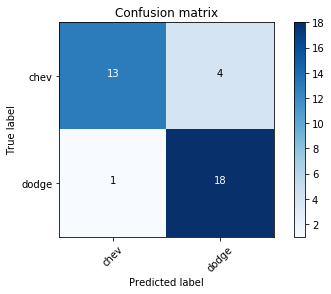

In [40]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [41]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect dodges


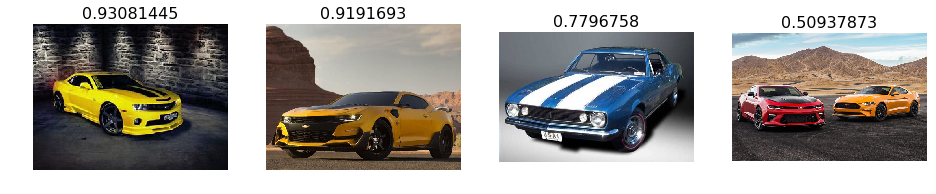

In [42]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect dodges")

Most incorrect chevs


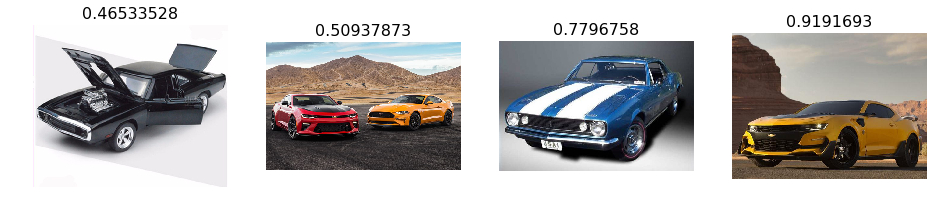

In [43]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect chevs")